In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import os


from matplotlib.animation import FuncAnimation, PillowWriter



def calculate_dihedrals_batch(molecules, indices) -> np.array:
    """
    Calculate dihedral angles for a batch of molecules in a vectorized manner.
    
    Parameters:
    molecules (np.ndarray): Array of shape (n_molecules, n_atoms, 3) containing the coordinates of the atoms in each molecule.
    indices (list): List of 4 indices that define the dihedral angle for all molecules.
    
    Returns:
    np.ndarray: Array of dihedral angles for the batch of molecules.
    """
    n_molecules = molecules.shape[0]
    
    # Extract coordinates of the four atoms for all molecules
    p0 = molecules[:, indices[0], :]
    p1 = molecules[:, indices[1], :]
    p2 = molecules[:, indices[2], :]
    p3 = molecules[:, indices[3], :]
    
    # Compute the vectors between the points
    b0 = p1 - p0
    b1 = p2 - p1
    b2 = p3 - p2
    
    # Normalize b1
    b1 /= np.linalg.norm(b1, axis=1)[:, np.newaxis]
    
    # Compute normal vectors to the planes
    n0 = np.cross(b0, b1)
    n1 = np.cross(b1, b2)
    
    # Normalize the normal vectors
    n0 /= np.linalg.norm(n0, axis=1)[:, np.newaxis]
    n1 /= np.linalg.norm(n1, axis=1)[:, np.newaxis]
    
    # Compute the dihedral angles
    m1 = np.cross(n0, b1)
    x = np.einsum('ij,ij->i', n0, n1)
    y = np.einsum('ij,ij->i', m1, n1)
    angles = -np.degrees(np.arctan2(y, x))
    
    return angles
    

In [2]:
def plot_histogram(hist, xedges, yedges):
    plt.imshow(hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
    plt.colorbar()
    plt.xlabel('φ')
    plt.ylabel('Ψ')
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.title('Histogram of dihedral angles (log scale)')
    plt.tight_layout()
    plt.savefig('../../gnn/histogram_train.png')
    #plt.show()
def read_xyz(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        coordinates = []
        sum = 0
        molecules = []
        energies = []
        while True:
            if sum >= len(lines):
                break
            num_atoms = int(lines[sum])
            coordinates = []
            energies.append(float(lines[sum+1]))
            for line in lines[sum+2:sum+num_atoms+2]:
                atom, x, y, z, fx, fy, fz = line.split()
                coordinates.append([float(x), float(y), float(z)])
            sum += num_atoms + 2
            molecules.append(coordinates)
        molecules = np.array(molecules)
        energies = np.array(energies)
        return molecules, energies

def plot_multiple_histograms(hists:list, xedges:list, yedges:list, titles:list = None):
    fig, axs = plt.subplots(1, len(hists), figsize=(15, 5))
    for i in range(len(hists)):
        hist = hists[i]
        xedge = xedges[i]
        yedge = yedges[i]
        axs[i].imshow(hist, origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], cmap='viridis')
        axs[i].set_xlabel('φ')
        axs[i].set_ylabel('Ψ')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()

def get_histogram_difference(hist1, hist2):

    return np.mean(np.abs(hist1 - hist2))

def create_single_hist(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        coordinates = []
        sum = 0
        molecules = []
        energies = []
        while True:
            if sum >= len(lines):
                break
            num_atoms = int(lines[sum])
            coordinates = []
            energies.append(float(lines[sum+1]))
            for line in lines[sum+2:sum+num_atoms+2]:
                atom, x, y, z, fx, fy, fz = line.split()
                coordinates.append([float(x), float(y), float(z)])
            sum += num_atoms + 2
            molecules.append(coordinates)
        molecules = np.array(molecules)
        energies = np.array(energies)
    print(len(molecules))

    indizes1 = [4, 6, 8, 14]
    indizes2 = [6, 8, 14, 16]   

    psi = calculate_dihedrals_batch(molecules, indizes1)
    phi = calculate_dihedrals_batch(molecules, indizes2)

    hist, xedges, yedges = np.histogram2d(phi, psi, bins=500, range=[[-180, 180], [-180, 180]])
    log_hist = hist#np.log(hist+1)
    plot_histogram(log_hist, xedges, yedges)


def single_scatter(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        coordinates = []
        sum = 0
        molecules = []
        energies = []
        while True:
            if sum >= len(lines):
                break
            num_atoms = int(lines[sum])
            coordinates = []
            energies.append(float(lines[sum+1]))
            for line in lines[sum+2:sum+num_atoms+2]:
                atom, x, y, z, fx, fy, fz = line.split()
                coordinates.append([float(x), float(y), float(z)])
            sum += num_atoms + 2
            molecules.append(coordinates)
        molecules = np.array(molecules)
        energies = np.array(energies)
    print(len(molecules))

    indizes1 = [4, 6, 8, 14]
    indizes2 = [6, 8, 14, 16]   

    psi = calculate_dihedrals_batch(molecules, indizes1)
    phi = calculate_dihedrals_batch(molecules, indizes2)

    plt.scatter(psi, phi, c=np.ones_like(psi), s=1) 
    plt.ylim(-180, 180)
    plt.xlim(-180, 180)
    plt.xlabel('φ')
    plt.ylabel('Ψ')
    plt.show()

def multi_scatter(paths):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    plt.figure()
    
    for i, path in enumerate(paths):
        with open(path, 'r') as f:
            lines = f.readlines()
            coordinates = []
            sum = 0
            molecules = []
            energies = []
            while True:
                if sum >= len(lines):
                    break
                num_atoms = int(lines[sum])
                coordinates = []
                energies.append(float(lines[sum+1]))
                for line in lines[sum+2:sum+num_atoms+2]:
                    atom, x, y, z, fx, fy, fz = line.split()
                    coordinates.append([float(x), float(y), float(z)])
                sum += num_atoms + 2
                molecules.append(coordinates)
            molecules = np.array(molecules)
            energies = np.array(energies)
        print(len(molecules))

        indizes1 = [4, 6, 8, 14]
        indizes2 = [6, 8, 14, 16]   

        psi = calculate_dihedrals_batch(molecules, indizes1)
        phi = calculate_dihedrals_batch(molecules, indizes2)

        plt.scatter(psi, phi, c=colors[i % len(colors)], s=2, label=f'{path}', alpha=1) 

    plt.ylim(-180, 180)
    plt.xlim(-180, 180)
    plt.xlabel('φ')
    plt.ylabel('Ψ')
    plt.legend()
    plt.show()



def animate_active_learning(base_path, paths, fps=15):
    
    fig, ax = plt.subplots()

    plt.ylim(-180, 180)
    plt.xlim(-180, 180)

    # Read initial data and calculate base dihedrals
    base_molecules, base_energies = read_xyz(base_path)
    indices1 = [4, 6, 8, 14]
    indices2 = [6, 8, 14, 16]
    base_psi = calculate_dihedrals_batch(base_molecules, indices1)
    base_phi = calculate_dihedrals_batch(base_molecules, indices2)

    # Initialize colors array: start with red for all base points
    colors = ["red"] * len(base_psi)

    # Create the initial scatter plot
    scatter = ax.scatter(base_psi, base_phi, s=2, c=colors)

    title = ax.set_title("Iteration: 0")


    # Update function for the animation
    def update(frame):
        nonlocal base_psi, base_phi, colors  # Ensure these variables are updated globally for each frame
        
        # Read new data for the current frame
        path = paths[frame]
        molecules, energies = read_xyz(path)
        new_psi = calculate_dihedrals_batch(molecules, indices1)
        new_phi = calculate_dihedrals_batch(molecules, indices2)

        # Append the new points to the cumulative lists
        base_psi = np.concatenate([base_psi, new_psi])
        base_phi = np.concatenate([base_phi, new_phi])

        # Update colors: set previous points to red, new points to blue
        colors = ["red"] * (len(base_psi) - len(new_psi)) + ["blue"] * len(new_psi)

        # Update scatter plot with new positions and colors
        scatter.set_offsets(np.c_[base_psi, base_phi])
        scatter.set_color(colors)

        title.set_text(f"Iteration: {frame + 1}")


        return scatter,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(paths), blit=False)  # Set blit=False for variable data

    # Save the animation as a GIF
    save_path = f"{"/".join(base_path.split("/")[:-2])}/plots/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    ani.save(save_path + "animation.gif", writer=PillowWriter(fps=fps))
            
    

In [ ]:
base_path = "../../al/run34/data/"
added_files = [f for f in os.listdir(base_path) if f.startswith("data_")]
num_files = len(added_files)
paths = [base_path + "dataset.xyz"]
paths.extend([base_path + f"data_{i}.xyz" for i in range(num_files)])
paths = np.array(paths)

#multi_scatter(paths[[-3,-2,-1]])
#multi_scatter(paths[:])
animate_active_learning(paths[0], paths[1:], fps=3)

: 

800
99
100


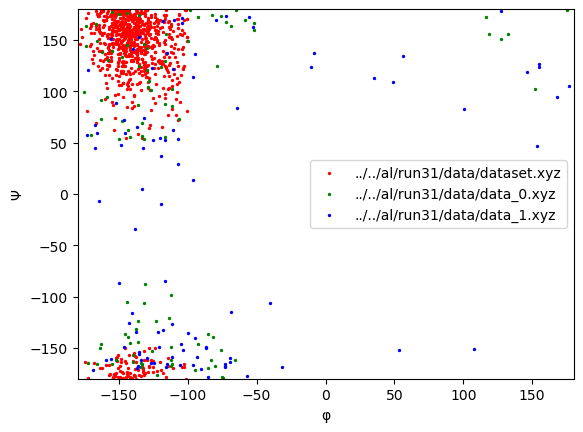

In [ ]:
base_path = "../../al/run31/data/"
added_files = [f for f in os.listdir(base_path) if f.startswith("data_")]
num_files = len(added_files)
paths = [base_path + "dataset.xyz"]
paths.extend([base_path + f"data_{i}.xyz" for i in range(num_files)])
paths = np.array(paths)

#multi_scatter(paths[[-3,-2,-1]])
multi_scatter(paths[[0,1,2]])
#animate_active_learning(paths[0], paths[1:], fps=3)

48745


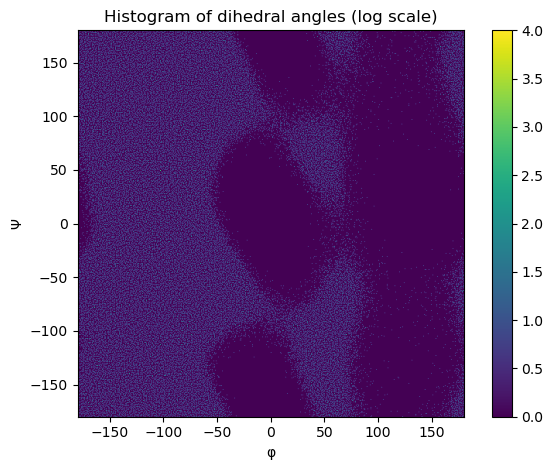

In [19]:
create_single_hist("../files/active_learning_validation2/dataset2.xyz")

In [15]:
# Load molecule coordinates from xyz file
xyz_file = '/home/kit/iti/fq0795/gnn_uncertainty/datasets/files/ala_converged_1000000/prod_positions_20-09-2023_13-10-19_energies_1,000,000.xyz'
train = "../files/ala_converged/dataset_1000_in_dist.xyz"
test_in = "../files/ala_converged/dataset_10000_validation_in_dist.xyz"
test_out = "../files/ala_converged/dataset_10000_validation_out_dist.xyz"


with open(train, 'r') as f:
    lines = f.readlines()
    coordinates = []
    sum = 0
    molecules = []
    energies = []
    while True:
        if sum >= len(lines):
            break
        num_atoms = int(lines[sum])
        coordinates = []
        energies.append(float(lines[sum+1]))
        for line in lines[sum+2:sum+num_atoms+2]:
            atom, x, y, z, fx, fy, fz = line.split()
            coordinates.append([float(x), float(y), float(z)])
        sum += num_atoms + 2
        molecules.append(coordinates)
    molecules_train = np.array(molecules)
    energies_train = np.array(energies)

with open(test_in, 'r') as f:
    lines = f.readlines()
    coordinates = []
    sum = 0
    molecules = []
    energies = []
    while True:
        if sum >= len(lines):
            break
        num_atoms = int(lines[sum])
        coordinates = []
        energies.append(float(lines[sum+1]))
        for line in lines[sum+2:sum+num_atoms+2]:
            atom, x, y, z, fx, fy, fz = line.split()
            coordinates.append([float(x), float(y), float(z)])
        sum += num_atoms + 2
        molecules.append(coordinates)
    molecules_test_in = np.array(molecules)
    energies_test_in = np.array(energies)

with open(test_out, 'r') as f:
    lines = f.readlines()
    coordinates = []
    sum = 0
    molecules = []
    energies = []
    while True:
        if sum >= len(lines):
            break
        num_atoms = int(lines[sum])
        coordinates = []
        energies.append(float(lines[sum+1]))
        for line in lines[sum+2:sum+num_atoms+2]:
            atom, x, y, z, fx, fy, fz = line.split()
            coordinates.append([float(x), float(y), float(z)])
        sum += num_atoms + 2
        molecules.append(coordinates)
    molecules_test_out = np.array(molecules)
    energies_test_out = np.array(energies)


FileNotFoundError: [Errno 2] No such file or directory: '../files/ala_converged/dataset_1000_in_dist.xyz'

In [5]:
indizes1 = [4, 6, 8, 14]
indizes2 = [6, 8, 14, 16]   

psi_train = calculate_dihedrals_batch(molecules_train, indizes1)
phi_train = calculate_dihedrals_batch(molecules_train, indizes2)

psi_test_in = calculate_dihedrals_batch(molecules_test_in, indizes1)
phi_test_in = calculate_dihedrals_batch(molecules_test_in, indizes2)

psi_test_out = calculate_dihedrals_batch(molecules_test_out, indizes1)
phi_test_out = calculate_dihedrals_batch(molecules_test_out, indizes2)

"plt.show()\nplt.scatter(psi_xyz, phi_xyz, c=energies, cmap='Blues', s=2)\nplt.colorbar(label='Energy')\nplt.xlabel('Phi')\nplt.ylabel('Psi')\nplt.title('Energy vs Psi-Phi Combination')\nplt.show()\n"

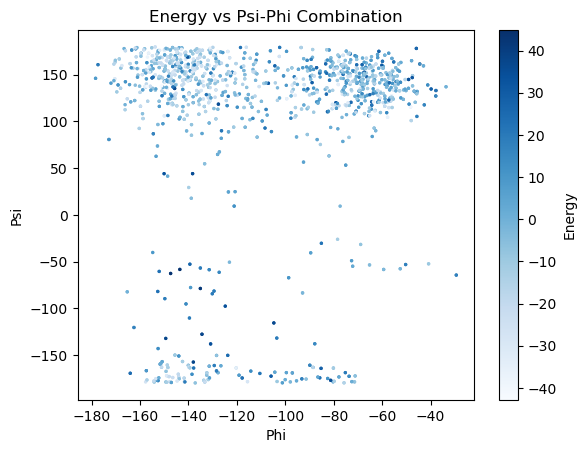

In [45]:
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.scatter(psi_xyz, phi_xyz, c=energies, cmap='Blues', s=2)
plt.colorbar(label='Energy')
plt.xlabel('Phi')
plt.ylabel('Psi')
plt.title('Energy vs Psi-Phi Combination')

# Apply Gaussian smoothing to the scatter plot
smoothed = gaussian_filter(energies, sigma=1, radius=20)
plt.scatter(psi_xyz, phi_xyz, c=smoothed, cmap='Blues', s=2)

'''plt.show()
plt.scatter(psi_xyz, phi_xyz, c=energies, cmap='Blues', s=2)
plt.colorbar(label='Energy')
plt.xlabel('Phi')
plt.ylabel('Psi')
plt.title('Energy vs Psi-Phi Combination')
plt.show()
'''

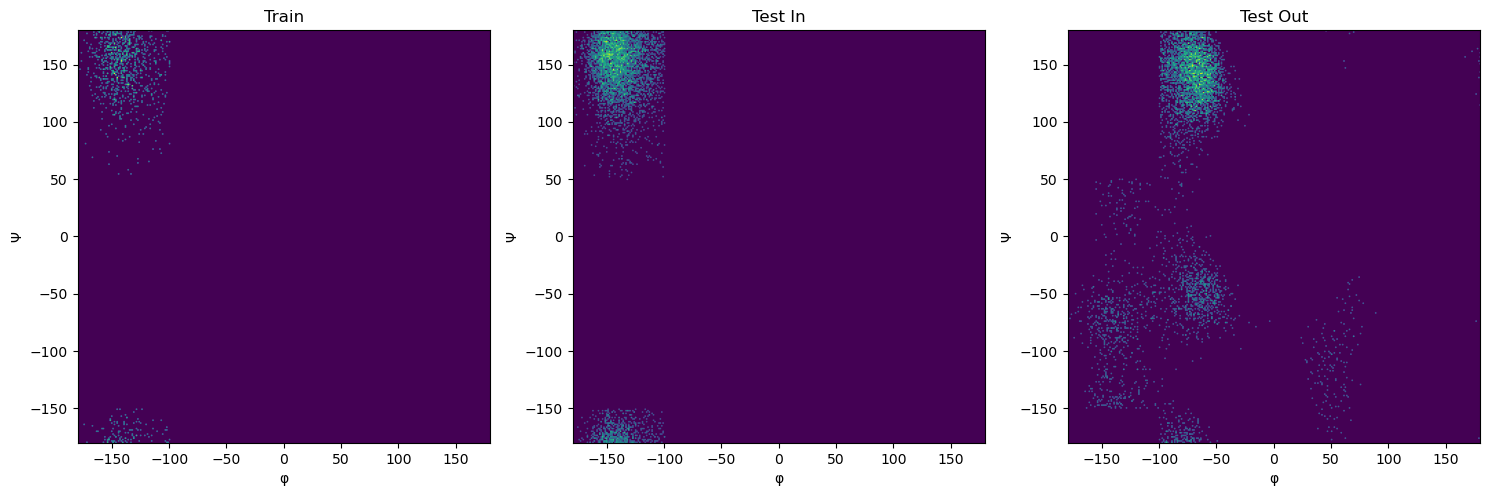

In [7]:
hist_train, xedges_train, yedges_train = np.histogram2d(phi_train, psi_train, bins=300, range=[[-180, 180], [-180, 180]])
log_hist_xyz = np.log(hist_train+1)


hist_test_in, xedges_test_in, yedges_test_in = np.histogram2d(phi_test_in, psi_test_in, bins=300, range=[[-180, 180], [-180, 180]])
log_hist_test_in = np.log(hist_test_in+1)


hist_test_out, xedges_test_out, yedges_test_out = np.histogram2d(phi_test_out, psi_test_out, bins=300, range=[[-180, 180], [-180, 180]])
log_hist_test_out = np.log(hist_test_out+1)

plot_multiple_histograms([log_hist_xyz, log_hist_test_in, log_hist_test_out], [xedges_train, xedges_test_in, xedges_test_out], [yedges_train, yedges_test_in, yedges_test_out], titles=['Train', 'Test In', 'Test Out'])

In [7]:
indizes1 = [4, 6, 8, 14]
indizes2 = [6, 8, 14, 16]    


traj_paper = np.load("/Users/lukas/Documents/KIT/Masterarbeit/git/gnn_uncertainty/datasets/files/ala_converged/test_cartesian.npy")
traj_henrik = np.load("/Users/lukas/Documents/KIT/Masterarbeit/git/gnn_uncertainty/datasets/files/ala_converged/prod_positions_20-09-2023_13-10-19.npy")


start_time = time.time()
psi_paper = calculate_dihedrals_batch(traj_paper, indizes1)
phi_paper = calculate_dihedrals_batch(traj_paper, indizes2)
psi_henrik = calculate_dihedrals_batch(traj_henrik, indizes1)
phi_henrik = calculate_dihedrals_batch(traj_henrik, indizes2)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for calculate_dihedrals_batch: {elapsed_time} seconds")


Elapsed time for calculate_dihedrals_batch: 120.13185596466064 seconds


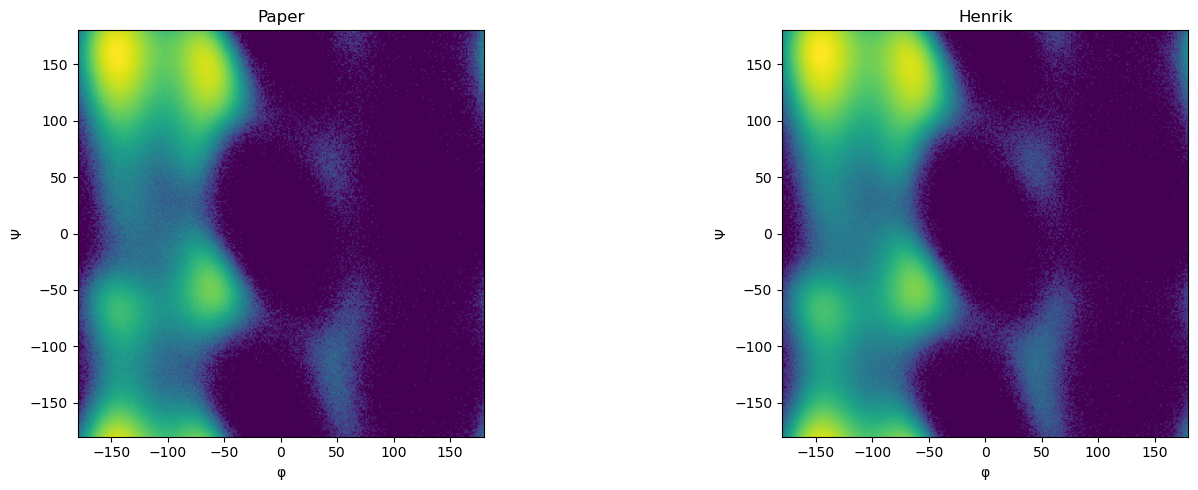

"\nplt.imshow(log_hist_henrik, origin='lower', extent=[xedges_henrik[0], xedges_henrik[-1], yedges_henrik[0], yedges_henrik[-1]], cmap='viridis')\nplt.colorbar()\nplt.xlabel('φ')\nplt.ylabel('Ψ')\nplt.title('Histogram of dihedral angles (log scale)')\nplt.show()\n"

In [60]:
# Calculate the logarithm of the occurrence count
hist_paper, xedges_paper, yedges_paper = np.histogram2d(phi_paper, psi_paper, bins=300)
hist_henrik, xedges_henrik, yedges_henrik = np.histogram2d(phi_henrik, psi_henrik, bins=300)
log_hist_paper = np.log(hist_paper+1)
log_hist_henrik = np.log(hist_henrik+1)


plot_multiple_histograms([log_hist_paper, log_hist_henrik], [xedges_paper, xedges_henrik], [yedges_paper, yedges_henrik], titles=["Paper", "Henrik"])
'''
plt.imshow(log_hist_henrik, origin='lower', extent=[xedges_henrik[0], xedges_henrik[-1], yedges_henrik[0], yedges_henrik[-1]], cmap='viridis')
plt.colorbar()
plt.xlabel('φ')
plt.ylabel('Ψ')
plt.title('Histogram of dihedral angles (log scale)')
plt.show()
'''

In [9]:
print(get_histogram_difference(log_hist_paper, log_hist_henrik))

0.3882490368091455


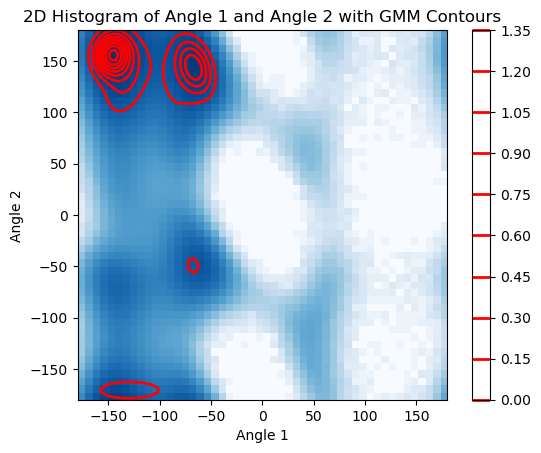

In [23]:
dihedral_angles = np.array([psi_henrik, phi_henrik]).T
scaler = StandardScaler()
dihedral_angles_scaled = scaler.fit_transform(dihedral_angles)

# Fit a Gaussian Mixture Model to the dihedral angles
gmm = GaussianMixture(n_components=5, init_params="kmeans", n_init=5)  # Change n_components as needed
gmm.fit(dihedral_angles_scaled)


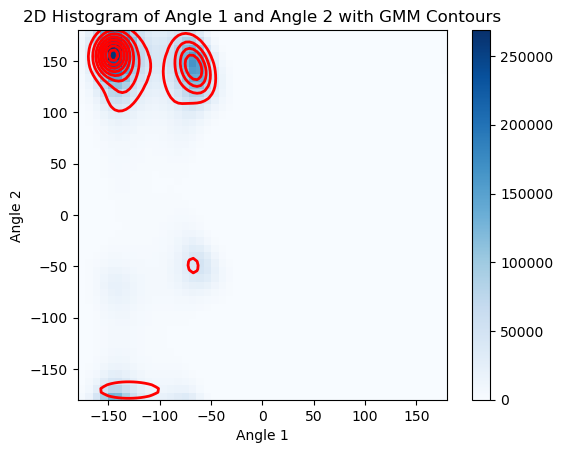

In [26]:
# plot the histogram
hist, xedges, yedges = np.histogram2d(phi_henrik, psi_henrik, bins=50)
plt.imshow(hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
plt.colorbar()

# Overlay the GMM contours

x = np.linspace(xedges_henrik[0], xedges_henrik[-1], 100)
y = np.linspace(yedges_henrik[0], yedges_henrik[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
XY_scaled = scaler.transform(XY)
Z = np.exp(gmm.score_samples(XY_scaled)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=2, colors='r')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Contours')
plt.show()

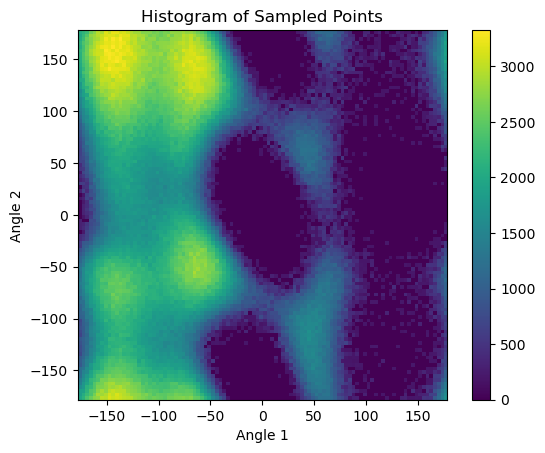

In [88]:
hist, xedges, yedges = np.histogram2d(phi_henrik, psi_henrik, bins=100)
log_hist = np.log(hist + 1)

# Generate sample points from the log-scaled histogram
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
x_samples, y_samples = np.meshgrid(x_centers, y_centers)
x_samples = x_samples.ravel()
y_samples = y_samples.ravel()
weights = log_hist.ravel()

# Subsample points according to log-scaled weights
probabilities = weights / weights.sum()
num_samples = 10000000  # Adjust the number of samples as needed
indices = np.random.choice(len(probabilities), size=num_samples, p=probabilities)
subsampled_points = np.column_stack([x_samples[indices], y_samples[indices]])

# Create a histogram from the sampled points
hist_samples, xedges_samples, yedges_samples = np.histogram2d(subsampled_points[:, 1], subsampled_points[:, 0], bins=100)

# Plot the histogram
plt.imshow(hist_samples, origin='lower', extent=[xedges_samples[0], xedges_samples[-1], yedges_samples[0], yedges_samples[-1]], cmap='viridis')
plt.colorbar()
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('Histogram of Sampled Points')
plt.show()

In [51]:
sampled_angles = subsampled_points

# Fit a Gaussian Mixture Model to the dihedral angles
gmm = GaussianMixture(n_components=8, init_params="kmeans", n_init=20)  # Change n_components as needed
gmm.fit(sampled_angles)

GaussianMixture(n_components=8, n_init=20)

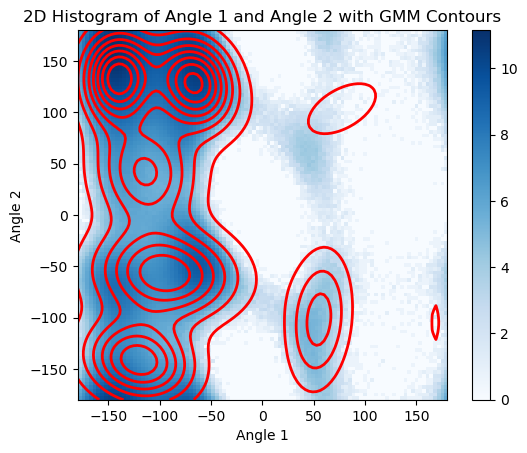

-11.4267908605869


In [52]:
# plot the histogram
plt.imshow(log_hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
plt.colorbar()

# Overlay the GMM contours

x = np.linspace(xedges_henrik[0], xedges_henrik[-1], 100)
y = np.linspace(yedges_henrik[0], yedges_henrik[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(gmm.score_samples(XY)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=2, colors='r')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Contours')
plt.show()
gmm_score = gmm.score(sampled_angles)
print(gmm_score)

In [54]:
# Fit a Gaussian Mixture Model to the dihedral angles
gmm = BayesianGaussianMixture(n_components=8)  # Change n_components as needed
gmm.fit(sampled_angles)

/Users/lukas/opt/miniconda3/envs/egnn/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=8)

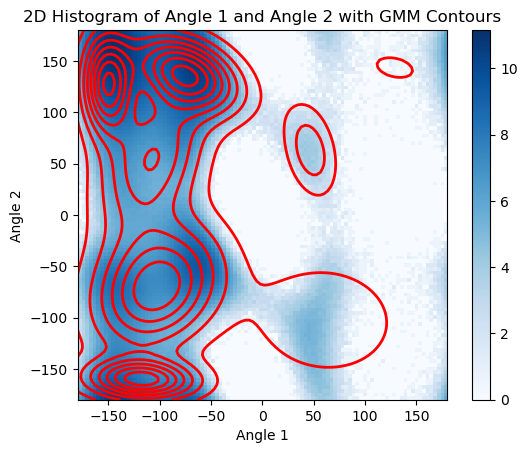

-11.42730777609223


In [55]:
# plot the histogram
plt.imshow(log_hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
plt.colorbar()

# Overlay the GMM contours

x = np.linspace(xedges_henrik[0], xedges_henrik[-1], 100)
y = np.linspace(yedges_henrik[0], yedges_henrik[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(gmm.score_samples(XY)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=2, colors='r')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Contours')
plt.show()
gmm_score = gmm.score(sampled_angles)
print(gmm_score)

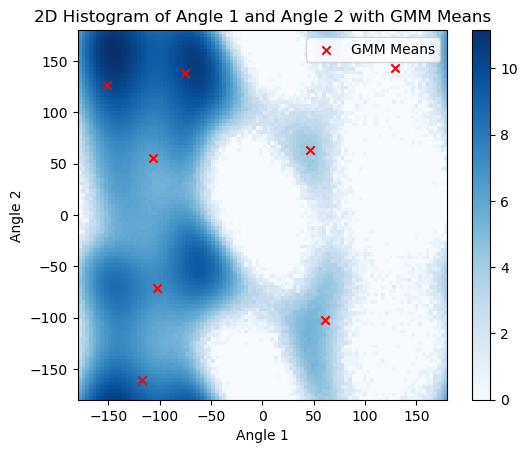

In [56]:
# Plot the histogram
plt.imshow(log_hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
plt.colorbar()

# Overlay the GMM means
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], c='r', marker='x', label='GMM Means')

plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Means')
plt.legend()
plt.show()

In [112]:
sampled_psi = x_samples[indices]
sampled_phi = y_samples[indices]

(10000000,)
(90000000,)


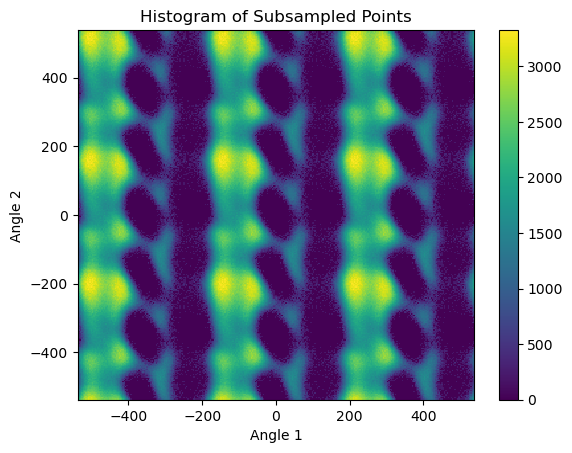

In [140]:
shift = 360
width = int(0.1 * 360)
sampled_psi = x_samples[indices]
sampled_phi = y_samples[indices]
indices_phi = np.where(sampled_phi < width)[0]
indices_psi = np.where(sampled_psi < width)[0]

sampled_phi_augmented = np.concatenate((sampled_phi, np.delete(sampled_phi + shift, indices_phi), sampled_phi - shift, sampled_phi, sampled_phi, sampled_phi[:width] + shift ,sampled_phi + shift, sampled_phi - shift, sampled_phi - shift))
sampled_psi_augmented = np.concatenate((sampled_psi, np.delete(sampled_psi, indices_phi), sampled_psi, sampled_psi + shift, sampled_psi - shift, sampled_psi + shift, sampled_psi - shift, sampled_psi + shift, sampled_psi - shift))
print(sampled_phi.shape)
print(sampled_phi_augmented.shape)

plt.hist2d(sampled_psi_augmented, sampled_phi_augmented, bins=300, cmap='viridis')
plt.colorbar()
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('Histogram of Subsampled Points')
plt.show()
subsampled_points_augmented = np.column_stack([sampled_phi_augmented, sampled_psi_augmented])

In [146]:
# Fit a Gaussian Mixture Model to the augmented data
subsampled_points_augmented = np.column_stack([sampled_phi_augmented, sampled_psi_augmented])
gmm = GaussianMixture(n_components=6*9)
gmm.fit(subsampled_points_augmented)


: 

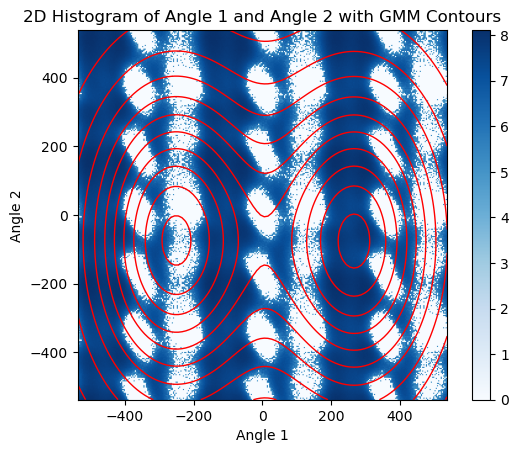

-13.780071784467575


In [ ]:
hist, xedges, yedges = np.histogram2d(sampled_phi_augmented, sampled_psi_augmented, bins=300)
log_hist = np.log(hist + 1)

# plot the histogram
plt.imshow(log_hist, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
plt.colorbar()

# Overlay the GMM contours

x = np.linspace(xedges[0], xedges[-1], 100)
y = np.linspace(yedges[0], yedges[-1], 100)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(gmm.score_samples(XY)).reshape(X.shape)
plt.contour(X, Y, Z, levels=10, linewidths=1, colors='r')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('2D Histogram of Angle 1 and Angle 2 with GMM Contours')
plt.show()
gmm_score = gmm.score(sampled_angles)
print(gmm_score)

# Kmeans Clustering

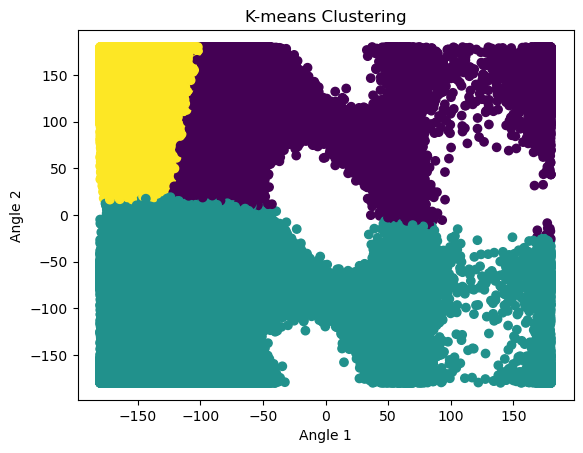

In [13]:
from sklearn.cluster import KMeans
n = 3
dihedral_angles = np.array([psi_henrik, phi_henrik]).T

# Perform K-means clustering
kmeans = KMeans(n_clusters=n)
kmeans.fit(dihedral_angles)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters
plt.scatter(dihedral_angles[:, 0], dihedral_angles[:, 1], c=labels, cmap='viridis')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('K-means Clustering')
plt.show()

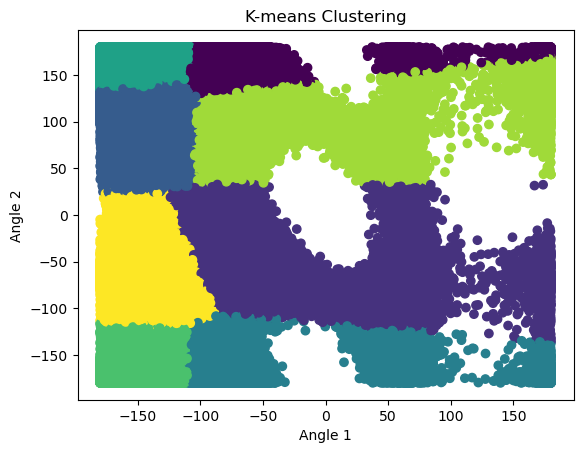

In [14]:
from sklearn.cluster import KMeans
n = 8
dihedral_angles = np.array([psi_henrik, phi_henrik]).T

# Perform K-means clustering
kmeans = KMeans(n_clusters=n)
kmeans.fit(dihedral_angles)

# Get the cluster labels
labels = kmeans.labels_

# Plot the clusters
plt.scatter(dihedral_angles[:, 0], dihedral_angles[:, 1], c=labels, cmap='viridis')
plt.xlabel('Angle 1')
plt.ylabel('Angle 2')
plt.title('K-means Clustering')
plt.show()